In [1]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


In [2]:
CONTEXT_WINDOW = 200  # words to display for context


In [ ]:
SEARCH_PHRASES = {
    'Million': r'\b(million|millions|million\'s|millions\'|million-\w+|\w+-million)[.,!?;:]*\b',
    'Time': r'\b(time|times|time\'s|times\'|time-\w+|\w+-time)[.,!?;:]*\b',
    'Money': r'\b(money|moneys|money\'s|moneys\'|money-\w+|\w+-money)[.,!?;:]*\b',
    'Feastable': r'\b(feastable|feastables|feastable\'s|feastables\'|feastable-\w+|\w+-feastable)[.,!?;:]*\b',
    'Water': r'\b(water|waters|water\'s|waters\'|water-\w+|\w+-water)[.,!?;:]*\b',
    'Insane': r'\b(insane|insanes|insane\'s|insanes\'|insane-\w+|\w+-insane)[.,!?;:]*\b',
    'Chocolate': r'\b(chocolate|chocolates|chocolate\'s|chocolates\'|chocolate-\w+|\w+-chocolate)[.,!?;:]*\b',
    'Survive': r'\b(survive|survives|survive\'s|survives\'|survive-\w+|\w+-survive)[.,!?;:]*\b',
    'Prize': r'\b(prize|prizes|prize\'s|prizes\'|prize-\w+|\w+-prize)[.,!?;:]*\b',
    'Challenge': r'\b(challenge|challenges|challenge\'s|challenges\'|challenge-\w+|\w+-challenge)[.,!?;:]*\b',
    'Camera': r'\b(camera|cameras|camera\'s|cameras\'|camera-\w+|\w+-camera)[.,!?;:]*\b',
    'Contestant': r'\b(contestant|contestants|contestant\'s|contestants\'|contestant-\w+|\w+-contestant)[.,!?;:]*\b',
    'Subscribe': r'\b(subscribe|subscribes|subscribe\'s|subscribes\'|subscribe-\w+|\w+-subscribe)[.,!?;:]*\b',
    'Beast': r'\b(beast|beasts|beast\'s|beasts\'|beast-\w+|\w+-beast)[.,!?;:]*\b',
    'Elimination': r'\b(elimination|eliminations|elimination\'s|eliminations\'|elimination-\w+|\w+-elimination)[.,!?;:]*\b',
    'Tesla': r'\b(tesla|teslas|tesla\'s|teslas\'|tesla-\w+|\w+-tesla)[.,!?;:]*\b',
    'Amazon': r'\b(amazon|amazons|amazon\'s|amazons\'|amazon-\w+|\w+-amazon)[.,!?;:]*\b',
    'Island': r'\b(island|islands|island\'s|islands\'|island-\w+|\w+-island)[.,!?;:]*\b',
    'Squid Game': r'\b(squid\s+game|squid\s+games|squid\s+game\'s|squid\s+games\'|squid-game|\w+-squid-game)[.,!?;:]*\b',
    'SeatGeek': r'\b(seatgeek|seatgeeks|seatgeek\'s|seatgeeks\'|seatgeek-\w+|\w+-seatgeek)[.,!?;:]*\b'
}

In [4]:
# def build_token_pattern(word: str) -> str:
#     # Match the exact stem, with allowed suffixes: s, 's, s', hyphen compounds
#     # Disallow longer alphabetic continuations (e.g., fireman, fired)
#     # Allow trailing punctuation
#     stem = re.escape(word.lower())
#     # Negative lookahead to prevent alphabetic continuation before suffix section
#     # Then allow optional: 's, s', s
#     # Then allow hyphen-compounds like word-xxx or xxx-word
#     # We implement hyphen compounds separately in the combined pattern
#     base = rf"\b{stem}(?![a-z])(?:'s|s'|s)?\b[.,!?;:]*"
#     return base

# # Hyphenated compound handling: either word-xxx or xxx-word
# # We'll integrate by OR-ing patterns for hyphenated forms.

# def build_hyphen_patterns(word: str) -> str:
#     stem = re.escape(word.lower())
#     # word-<letters>
#     left_hyphen = rf"\b{stem}-(?:[a-z]+)\b[.,!?;:]*"
#     # <letters>-word
#     right_hyphen = rf"\b(?:[a-z]+)-{stem}\b[.,!?;:]*"
#     return rf"(?:{left_hyphen}|{right_hyphen})"


# def build_phrase_pattern(entry: str) -> str:
#     # Entries may contain slashes to indicate synonyms that should count as one phrase
#     synonyms = [w.strip() for w in entry.split('/') if w.strip()]
#     parts = []
#     for w in synonyms:
#         parts.append(build_token_pattern(w))
#         parts.append(build_hyphen_patterns(w))
#     return rf"(?:{('|').join(parts)})"

# RAW_PHRASES = [
#     "Million",
#     "Time",
#     "Money",
#     "Feastable",
#     "Feast",
#     "Water",
#     "Insane",
#     "Chocolate",
#     "Survive",
#     "Prize",
#     "Challenge",
#     "Camera",
#     "Contestant",
#     "Subscribe",
#     "Beast",
#     "Elimination",
#     "Tesla",
#     "Amazon",
#     "Island",
#     "Squid Game",
#     "SeatGeek",
# ]

# # Build patterns dict similar to bernie notebook
# SEARCH_PHRASES = {}
# for p in RAW_PHRASES:
#     # Special handling for multi-word like "Squid Game": apply same suffix and hyphen rules to the last token only
#     if ' ' in p:
#         tokens = p.split()
#         last = tokens[-1]
#         prefix = ' '.join(tokens[:-1])
#         # prefix as fixed words, last with token+hyphen rules
#         last_pattern = build_token_pattern(last)
#         last_hyphen = build_hyphen_patterns(last)
#         SEARCH_PHRASES[p] = rf"\b{re.escape(prefix.lower())}\s+(?:{last_pattern}|{last_hyphen})"
#     else:
#         # For symbols like ¢, allow exact match with trailing punctuation
#         if re.search(r"[^A-Za-z ]", p) and p not in ("Subscribe", "Beast"):
#             escaped = re.escape(p.lower())
#             SEARCH_PHRASES[p] = rf"\b{escaped}\b[.,!?;:]*"
#         else:
#             SEARCH_PHRASES[p] = build_phrase_pattern(p)

# SEARCH_PHRASES


In [5]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    counts = {}
    lower_text = text.lower()
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, lower_text))
    return counts


def parse_upload_date(val: str) -> datetime:
    # Expecting format like 20250801 or ISO; try multiple formats
    s = str(val).strip()
    for fmt in ("%Y%m%d", "%Y-%m-%d", "%Y/%m/%d"):
        try:
            return datetime.strptime(s, fmt)
        except Exception:
            continue
    # Fallback to pandas to_datetime
    try:
        return pd.to_datetime(s).to_pydatetime()
    except Exception:
        return pd.NaT


def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    matches = []
    lower_text = text.lower()
    for match in re.finditer(pattern, lower_text):
        start = max(0, match.start() - window)
        end = min(len(lower_text), match.end() + window)
        snippet = lower_text[start:end]
        if start > 0:
            snippet = '...' + snippet
        if end < len(lower_text):
            snippet = snippet + '...'
        matches.append(snippet)
    return matches


In [6]:
# Load Mr. Beast transcripts CSV
CSV_PATH = "/Users/jstenger/Documents/repos/kalshi-research/data-beast/dataset_yt-transcript_2025-08-15_00-40-14-138.csv"

# Read with pandas; the file has embedded newlines inside quoted fields, so use python engine
raw = pd.read_csv(CSV_PATH, engine='python')

# Keep only necessary columns
# Expect columns: url, title, duration, uploadDate, language, text
cols = [c for c in raw.columns if c in ['url','title','duration','uploadDate','language','text']]
df_raw = raw[cols].copy()

# Normalize date
df_raw['date'] = df_raw['uploadDate'].apply(parse_upload_date)

# Drop rows without text
df_raw = df_raw[df_raw['text'].astype(str).str.len() > 0].copy()

# Compute counts
records = []
for _, row in df_raw.iterrows():
    text = str(row['text'])
    counts = count_phrases(text)
    rec = {
        'date': row['date'],
        'title': row.get('title', ''),
        'url': row.get('url', ''),
        'text_length': len(text.split()),
        'text': text,
    }
    rec.update(counts)
    records.append(rec)

df = pd.DataFrame(records).sort_values('date')

print("Dataset Statistics:")
print(f"Total videos: {len(df)}")
print("\nWord Count Statistics:")
print(f"Average length: {df['text_length'].mean():.0f} words")
print("\nDate Range:")
if pd.notna(df['date'].min()) and pd.notna(df['date'].max()):
    print(f"{df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
else:
    print("No valid dates")


Dataset Statistics:
Total videos: 59

Word Count Statistics:
Average length: 3862 words

Date Range:
2022-12-24 to 2025-08-16


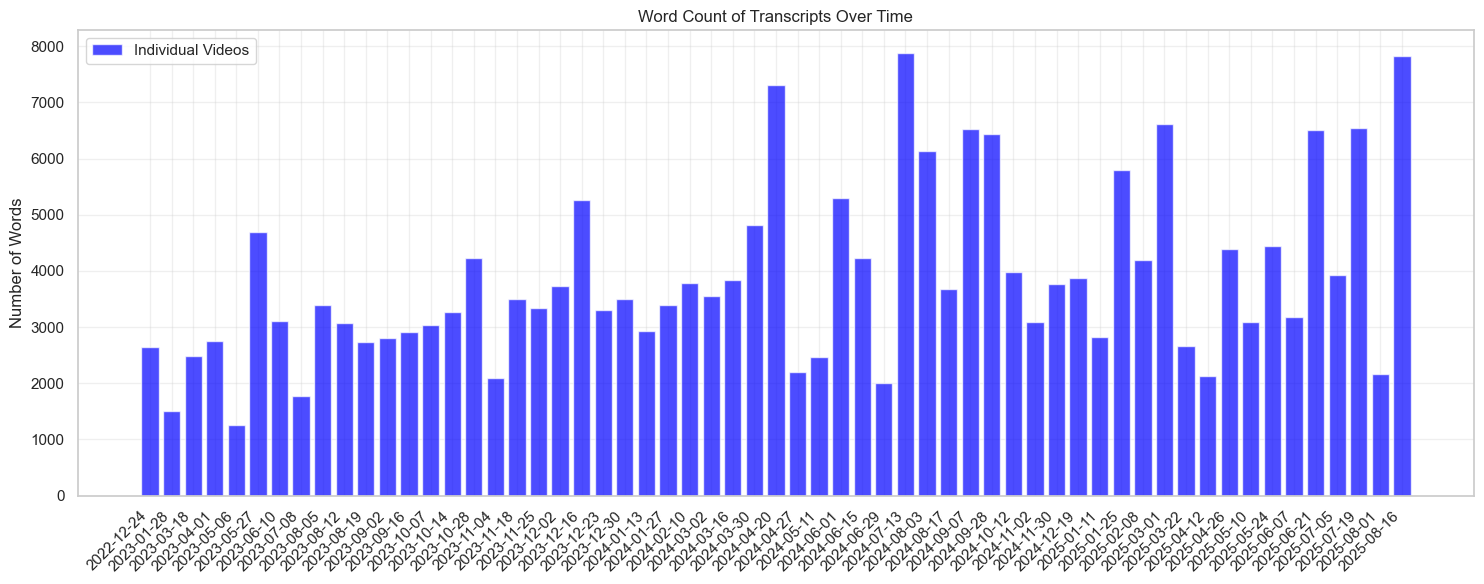


Word Count Summary:
Mean word count: 3862
Median word count: 3499
Min word count: 1260
Max word count: 7887


In [7]:
# Plot total word counts over time as a bar chart
plt.figure(figsize=(15, 6))

df_sorted = df.sort_values('date')
x_positions = range(len(df_sorted))

plt.bar(x_positions, df_sorted['text_length'], alpha=0.7, color='blue', label='Individual Videos')
plt.xticks(x_positions, [d.strftime('%Y-%m-%d') if pd.notna(d) else '' for d in df_sorted['date']], rotation=45, ha='right')
plt.title('Word Count of Transcripts Over Time')
plt.xlabel('')
plt.ylabel('Number of Words')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

print("\nWord Count Summary:")
print(f"Mean word count: {df['text_length'].mean():.0f}")
print(f"Median word count: {df['text_length'].median():.0f}")
print(f"Min word count: {df['text_length'].min():.0f}")
print(f"Max word count: {df['text_length'].max():.0f}")


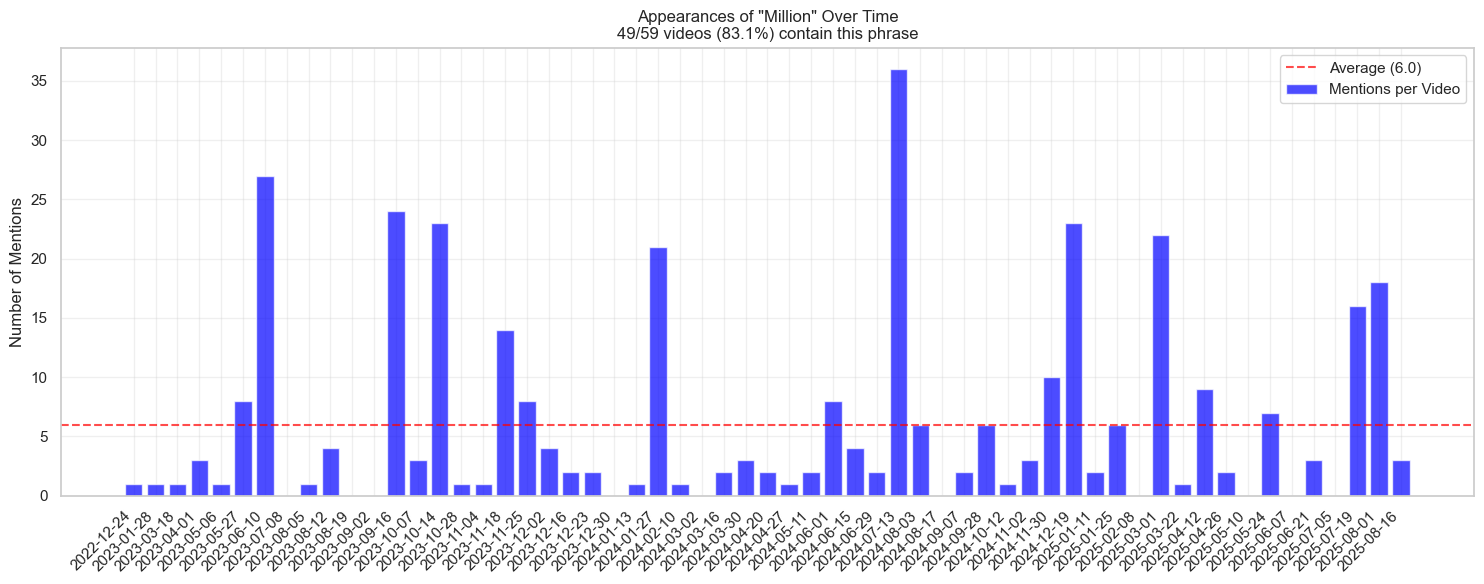

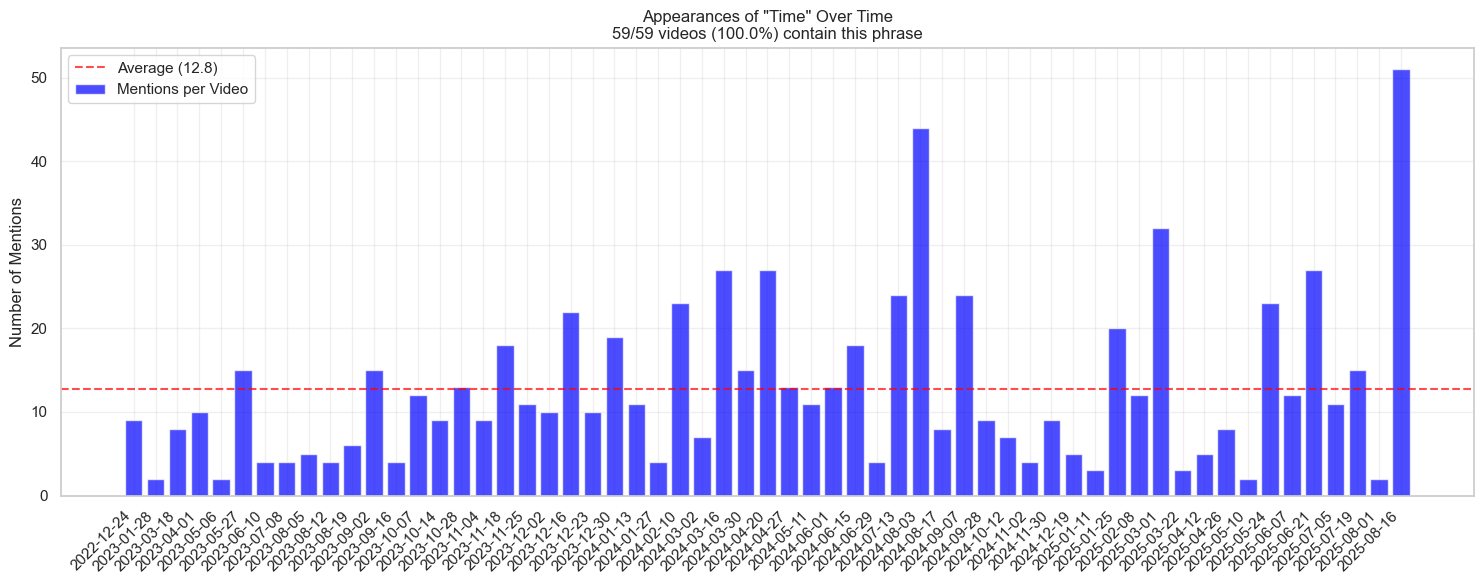

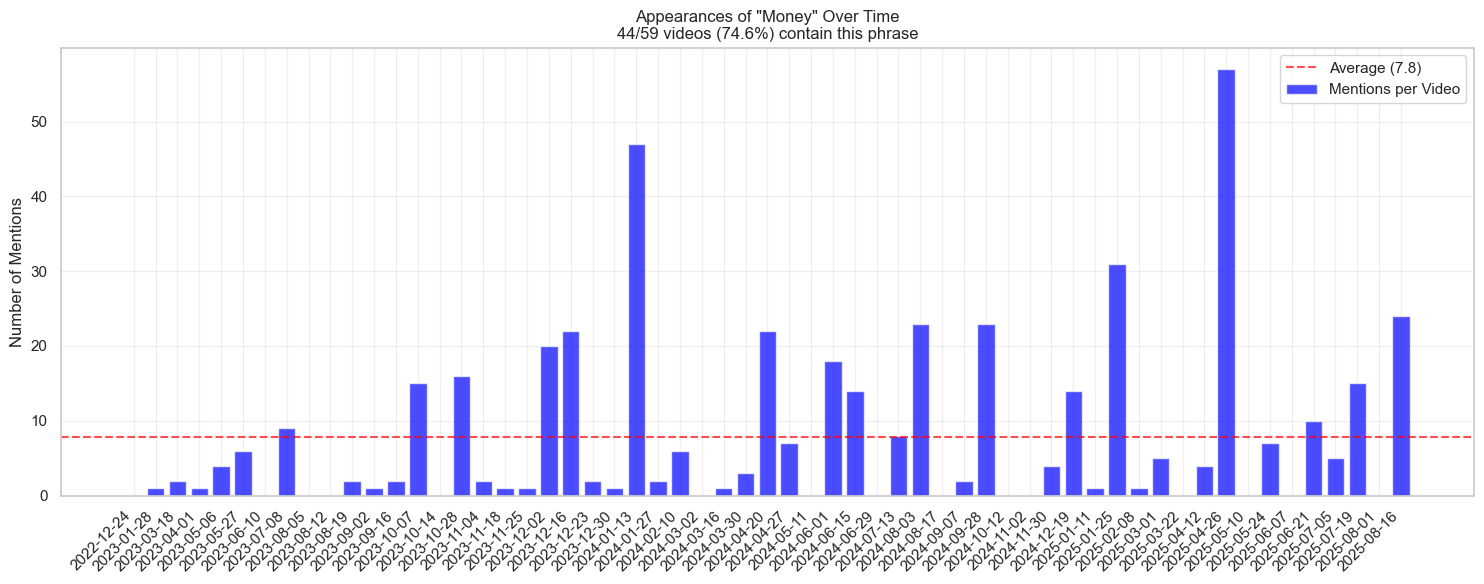

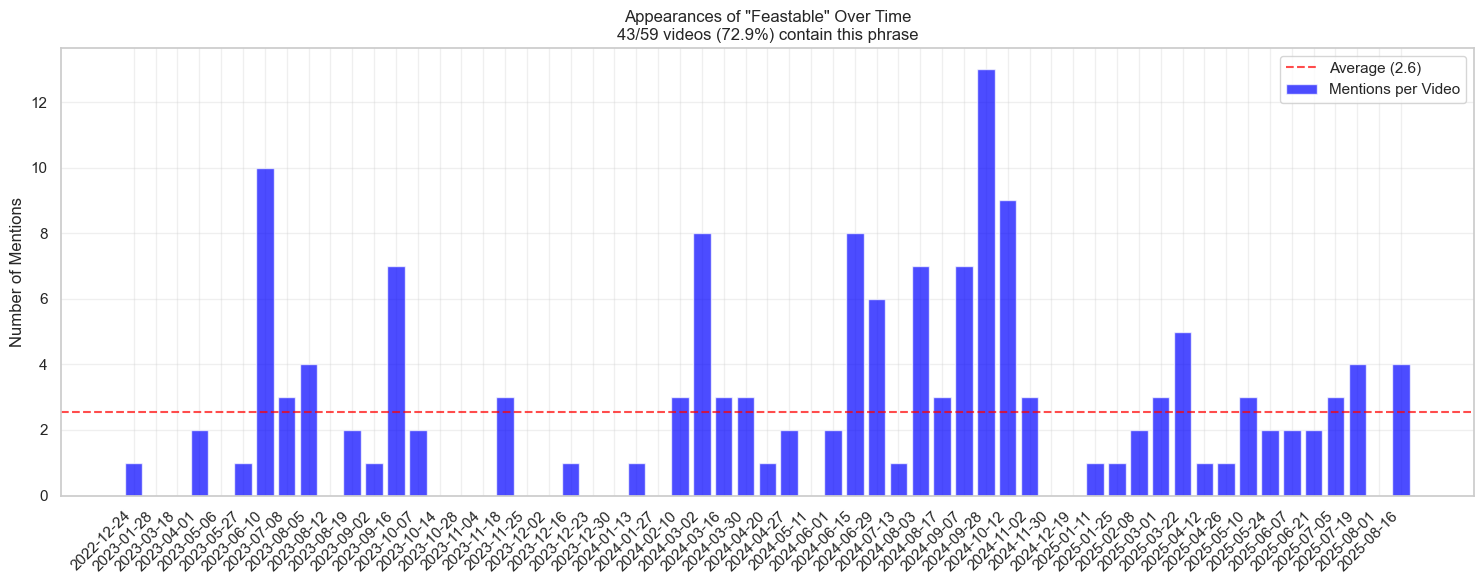

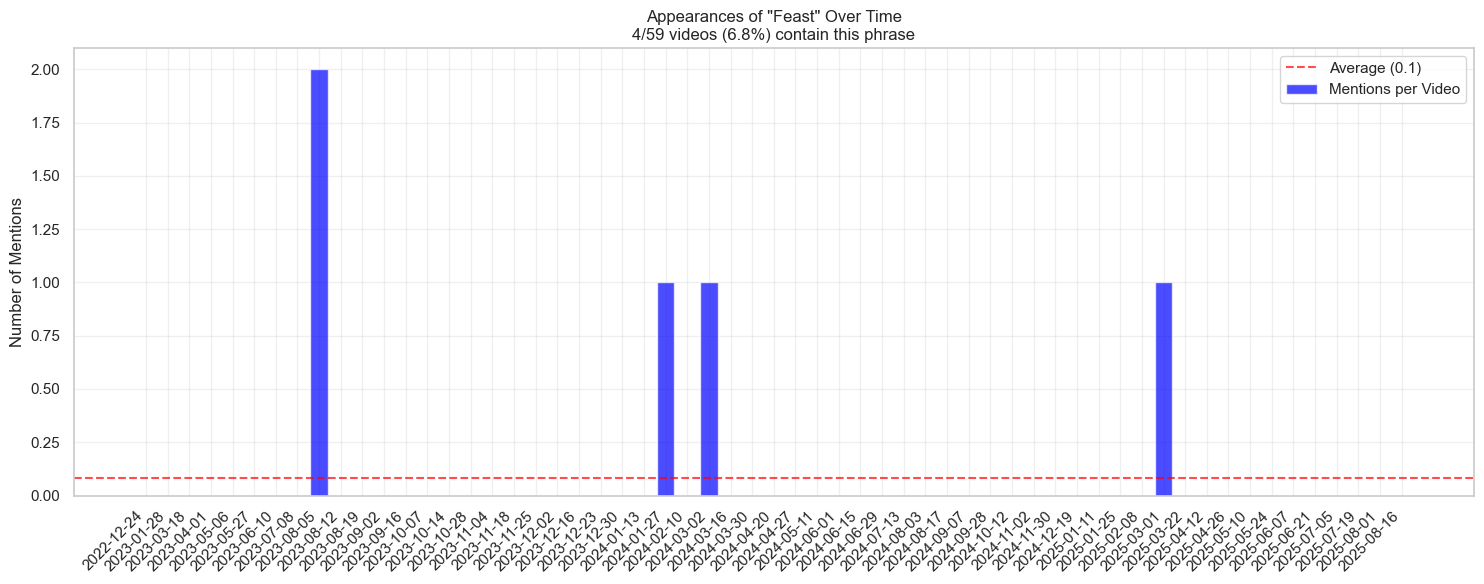

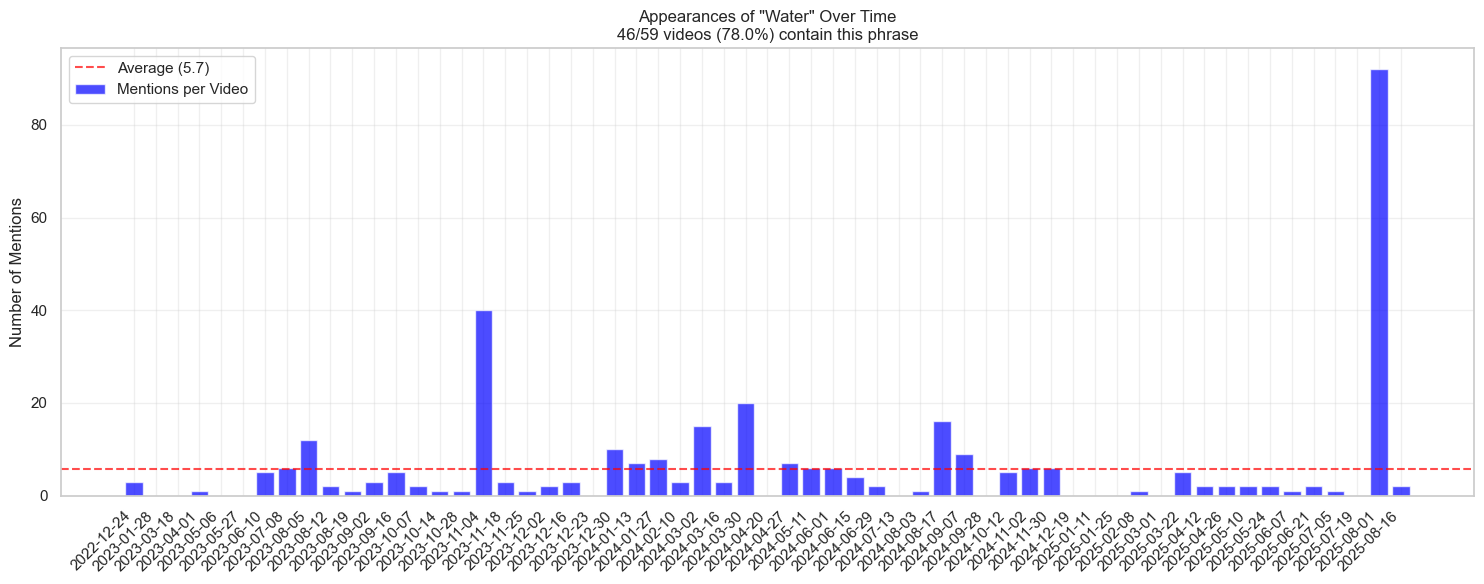

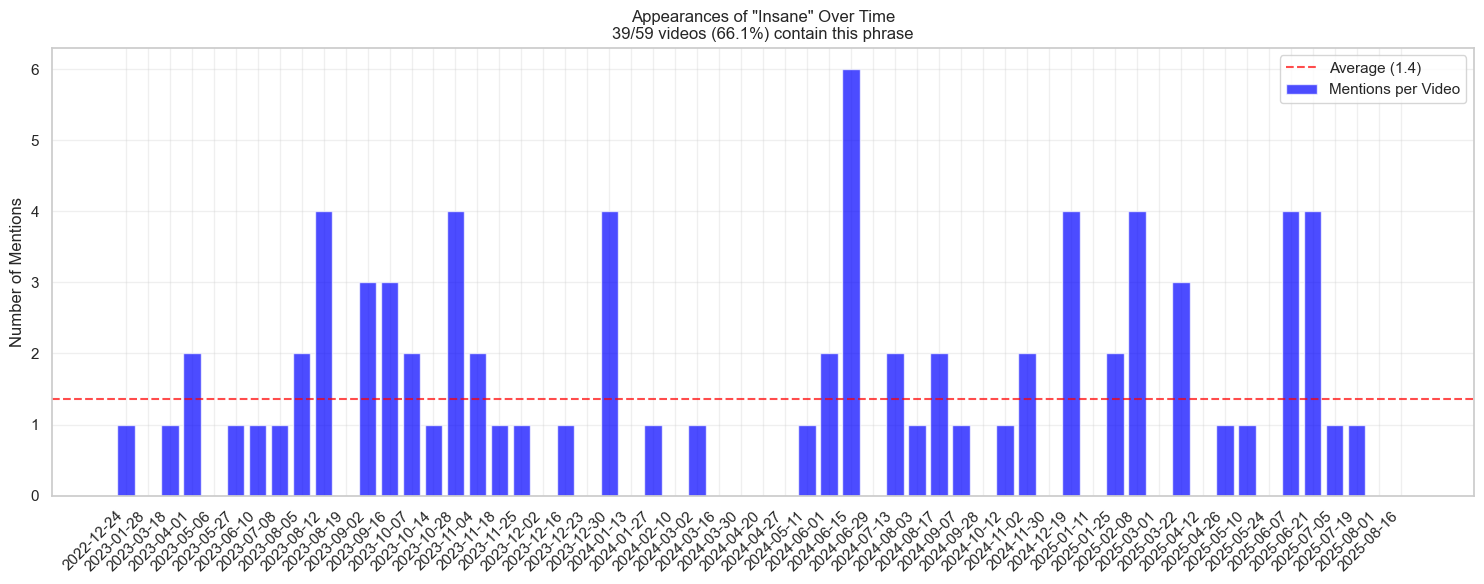

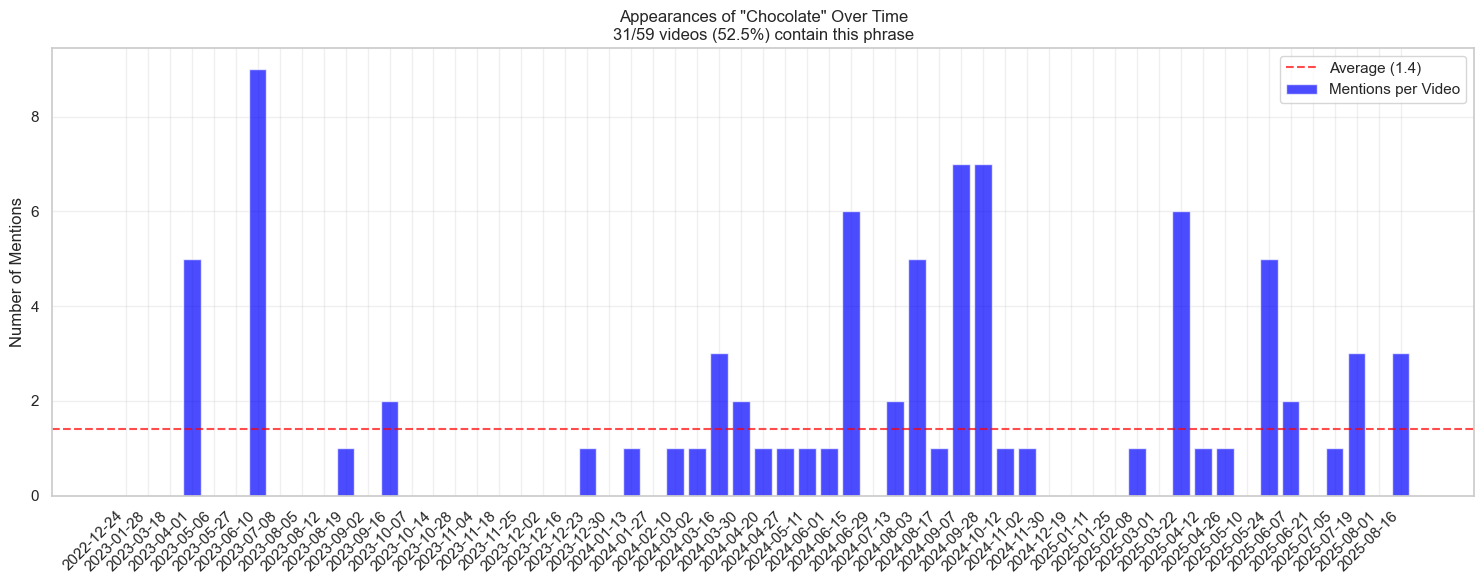

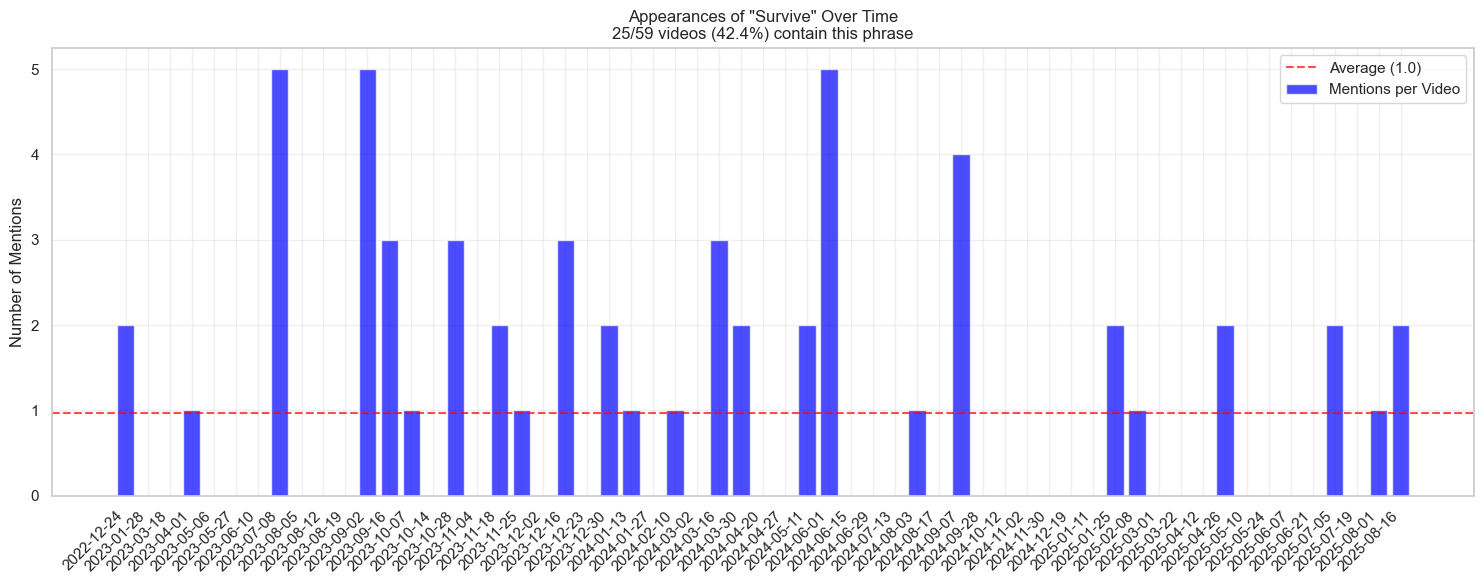

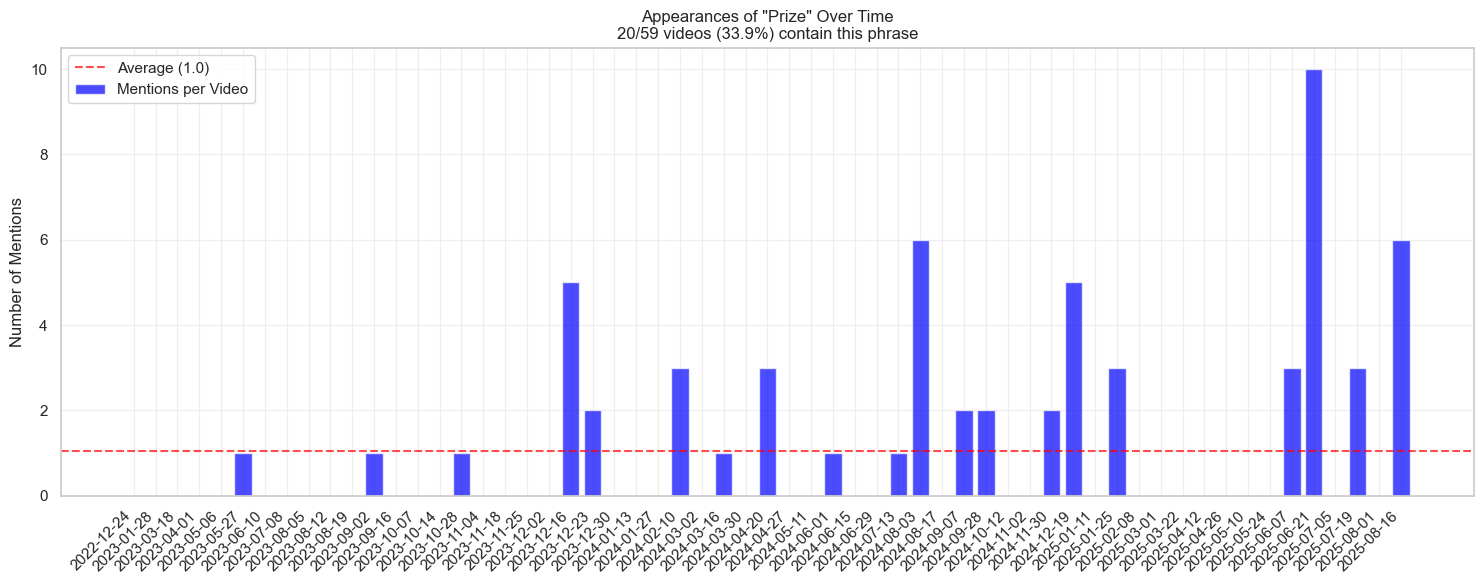

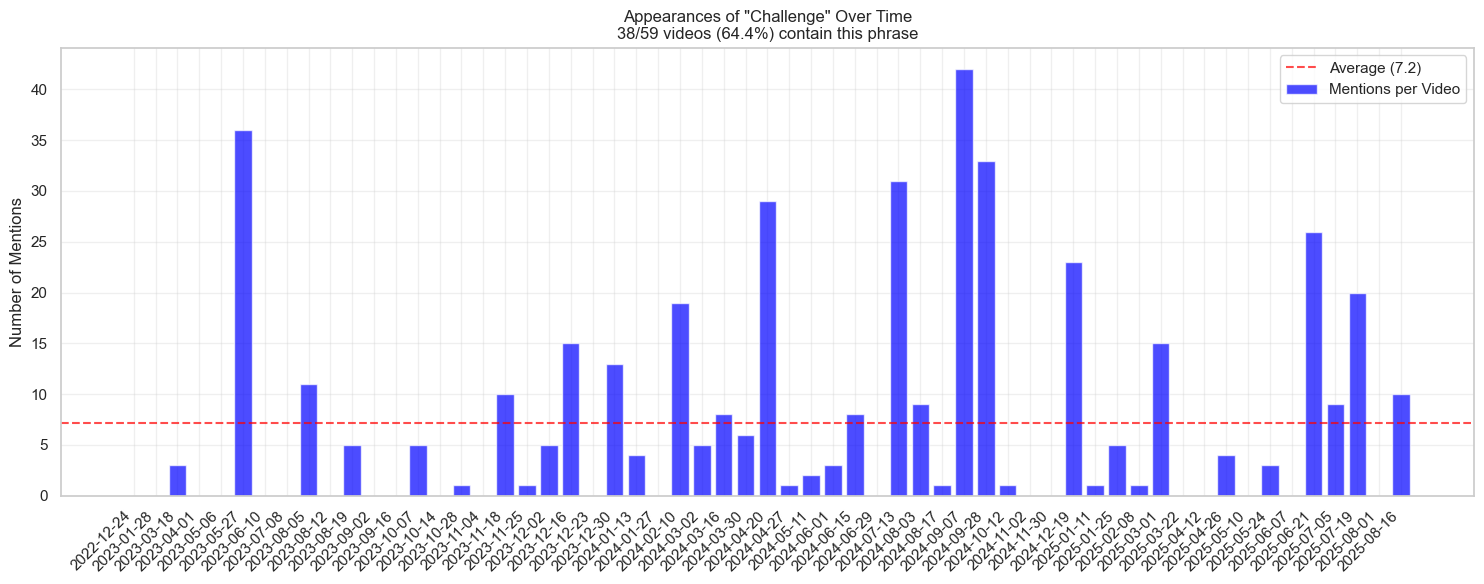

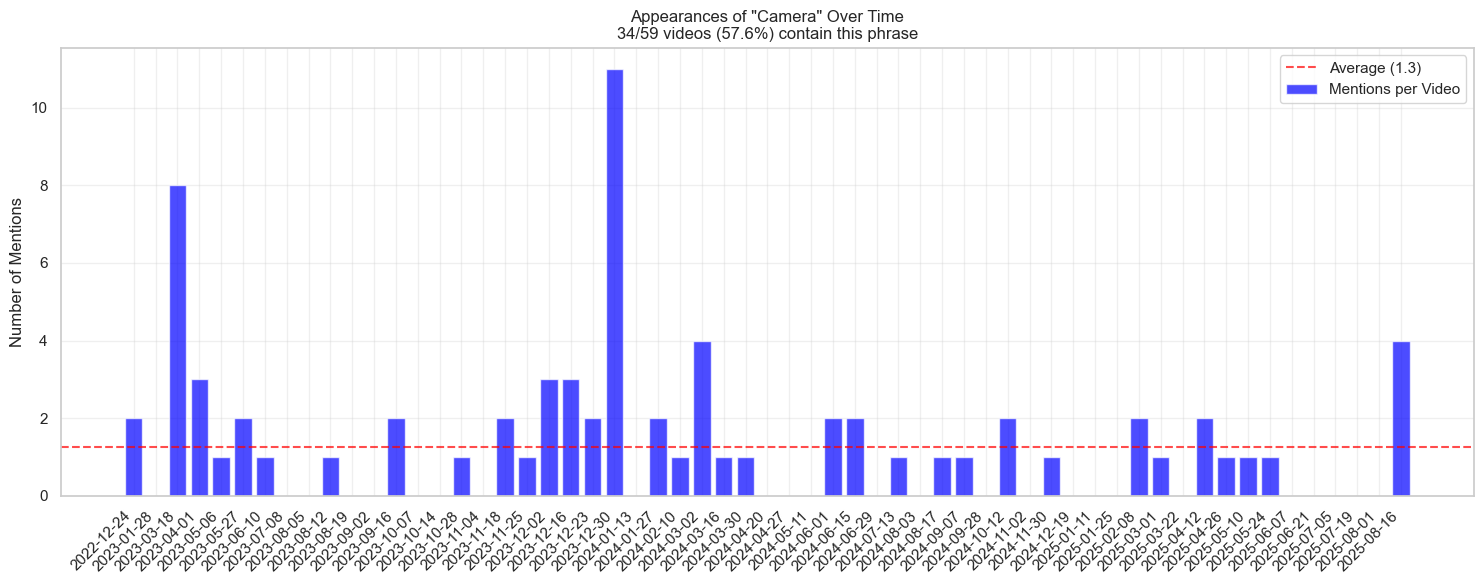

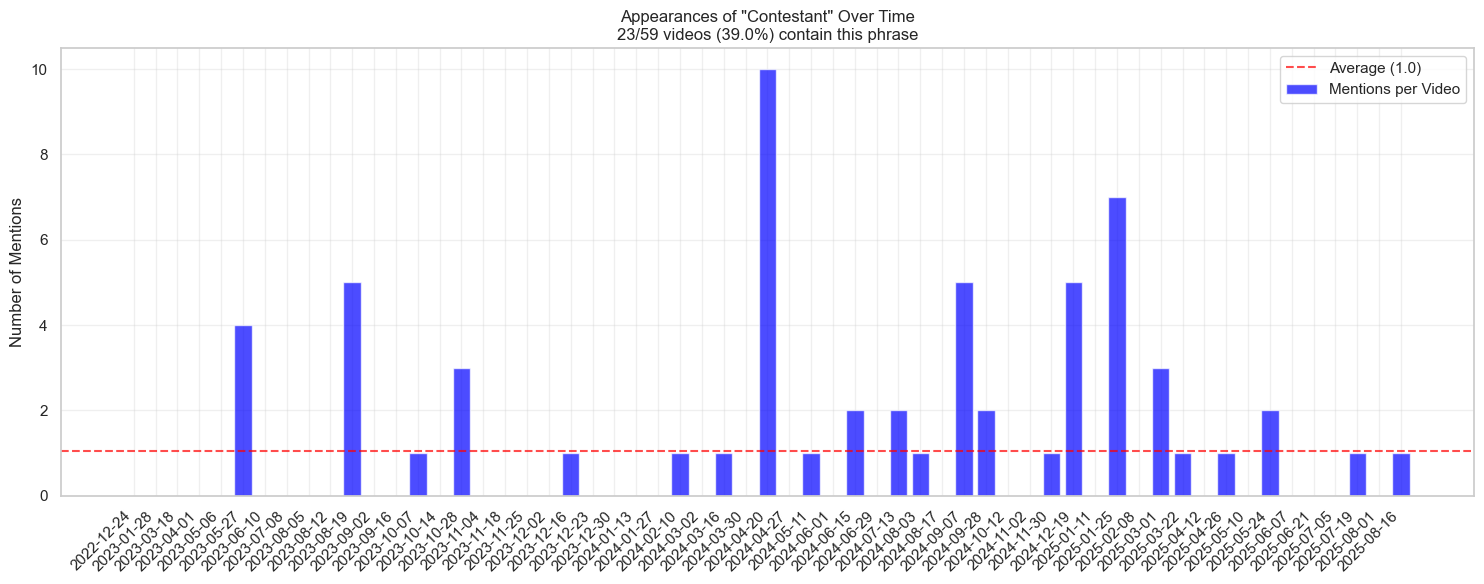

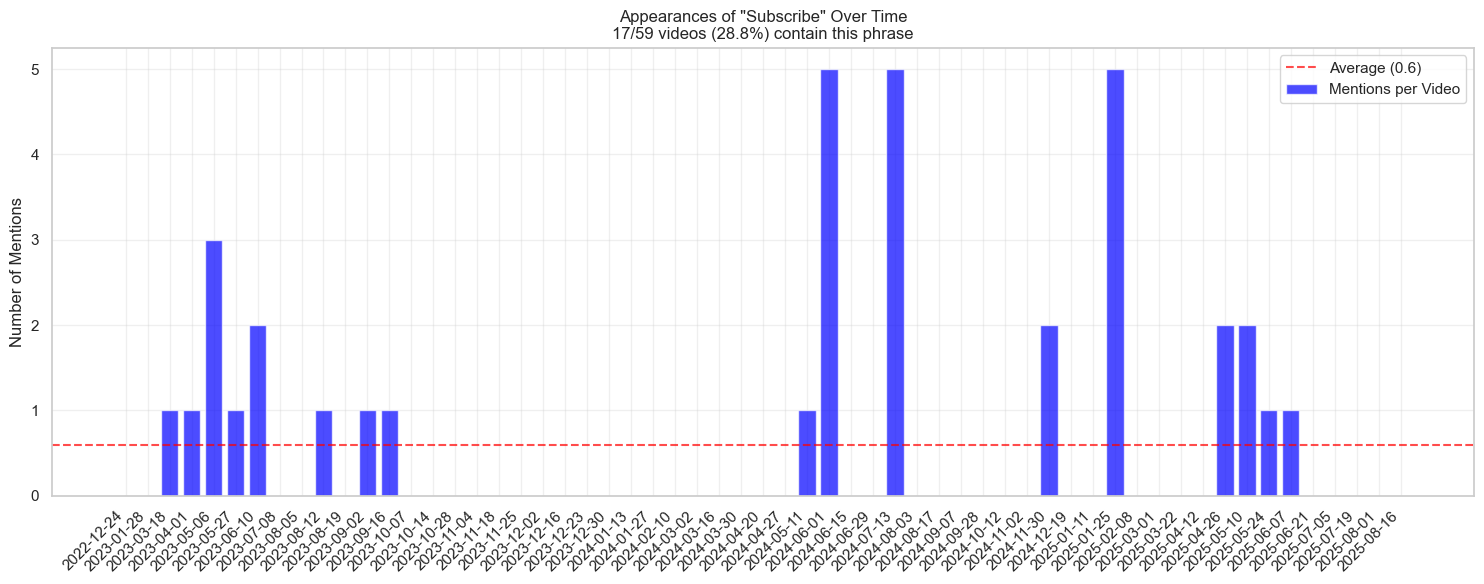

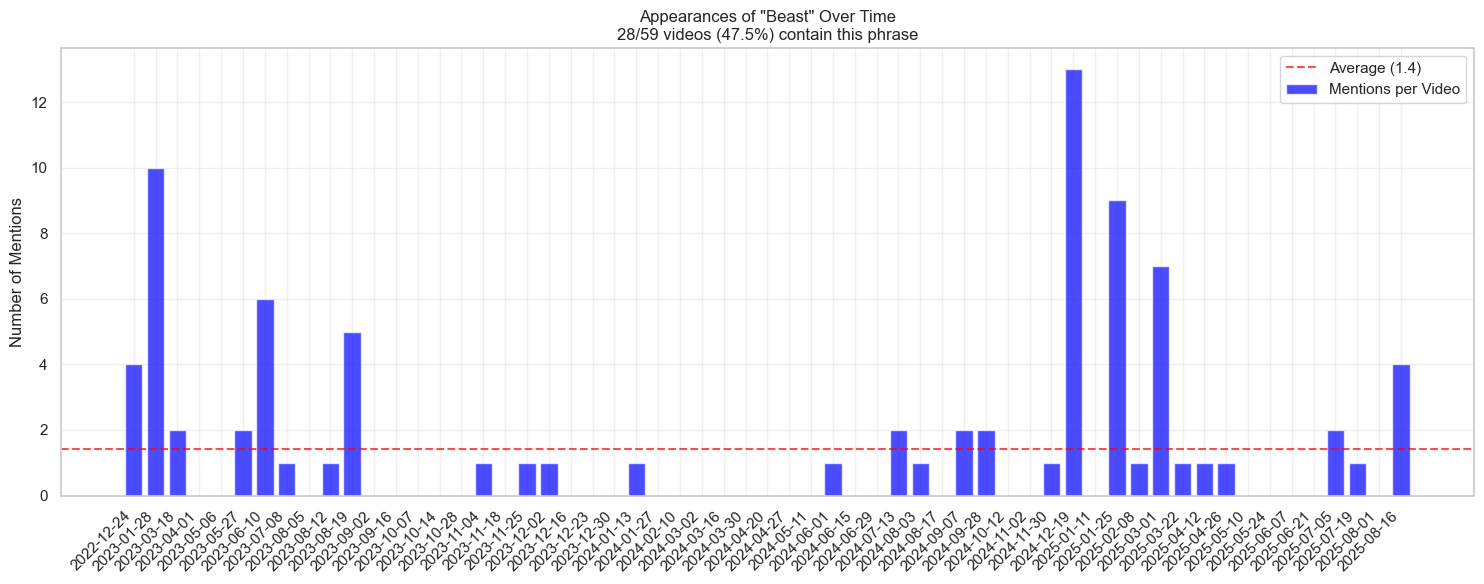

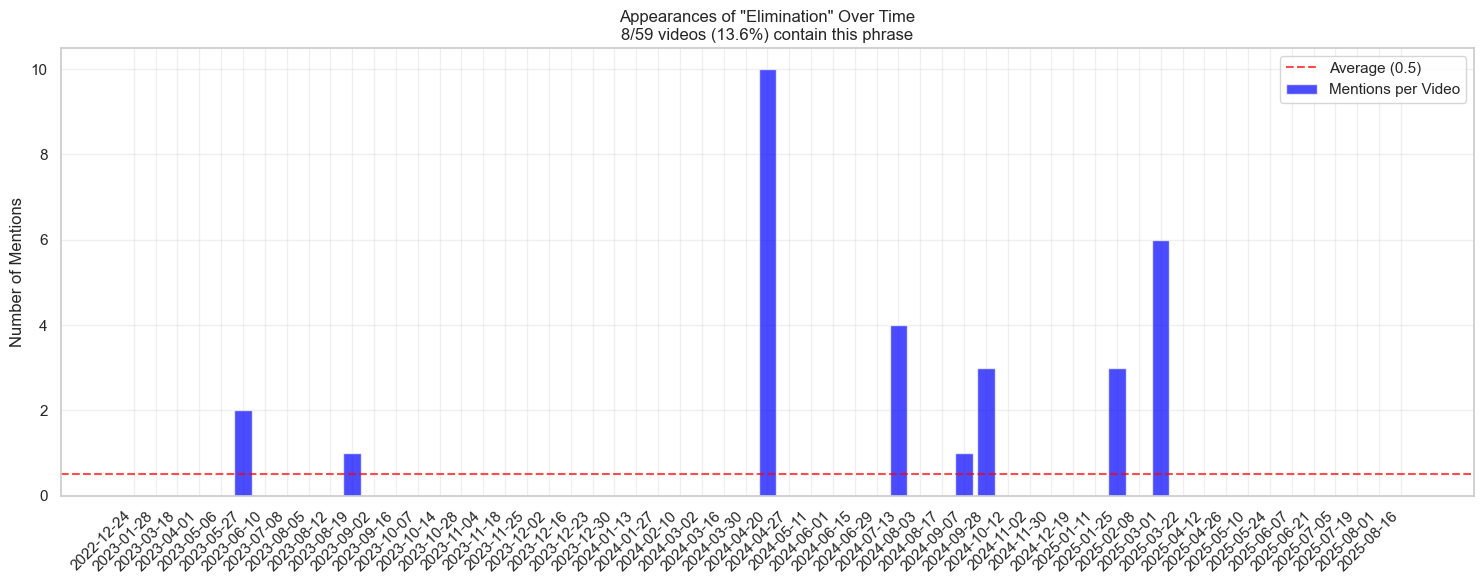

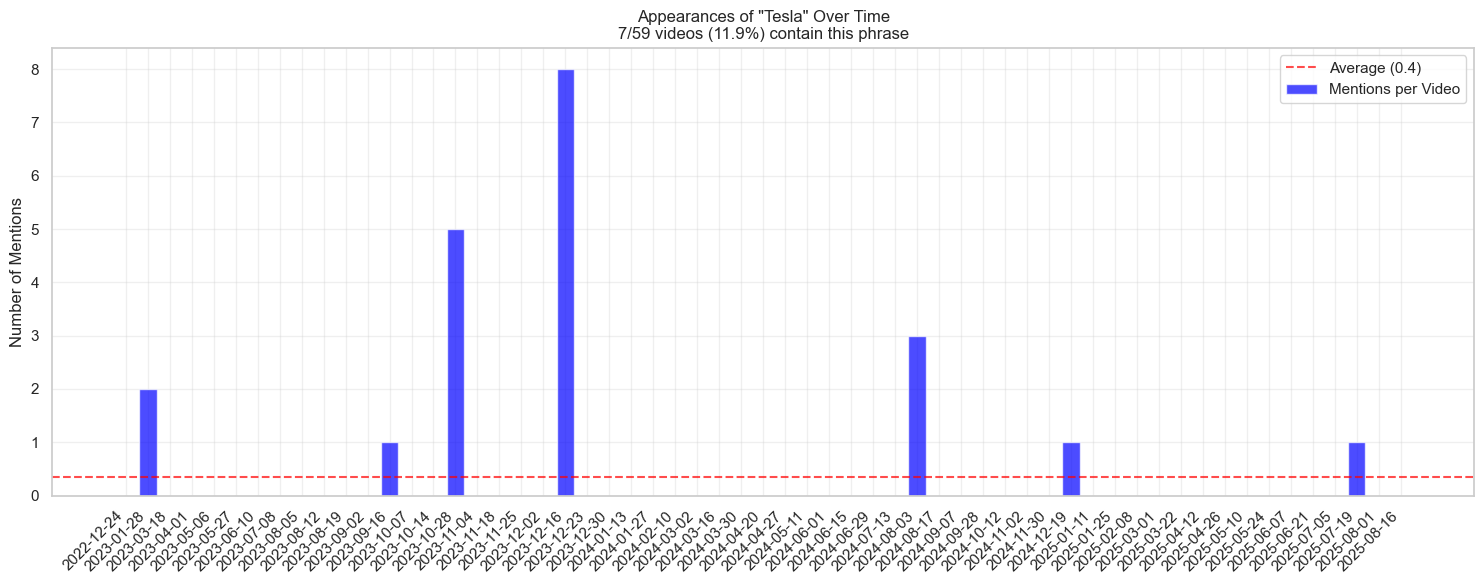

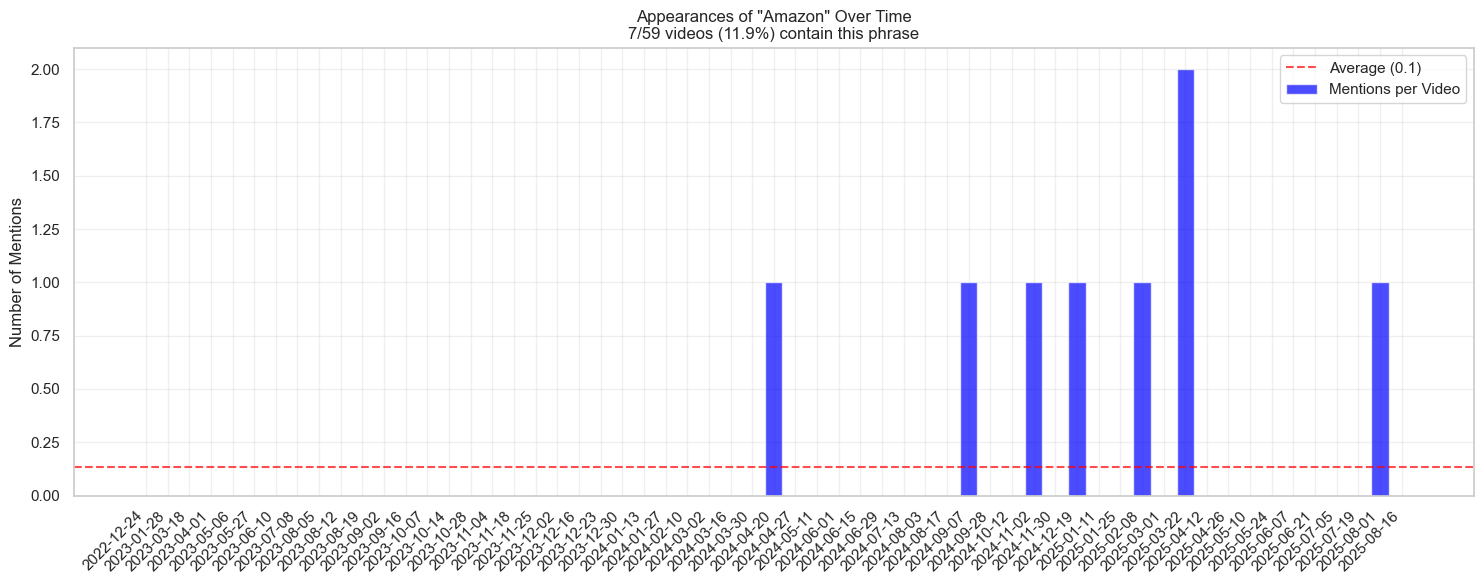

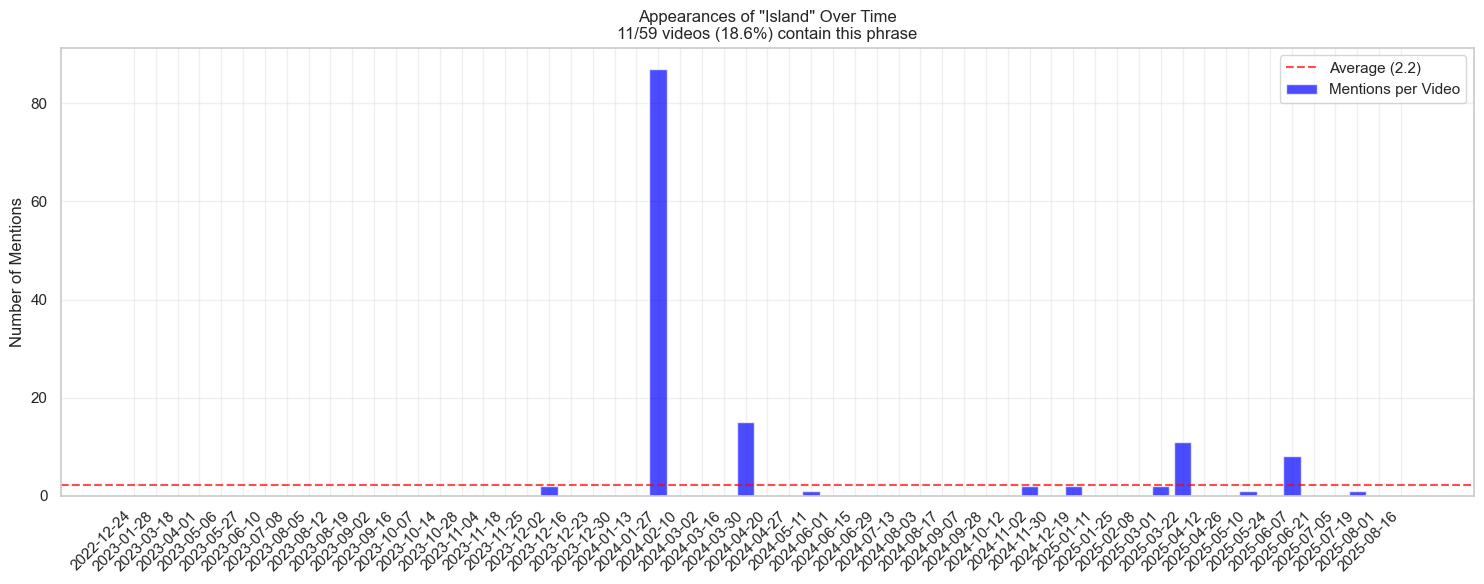

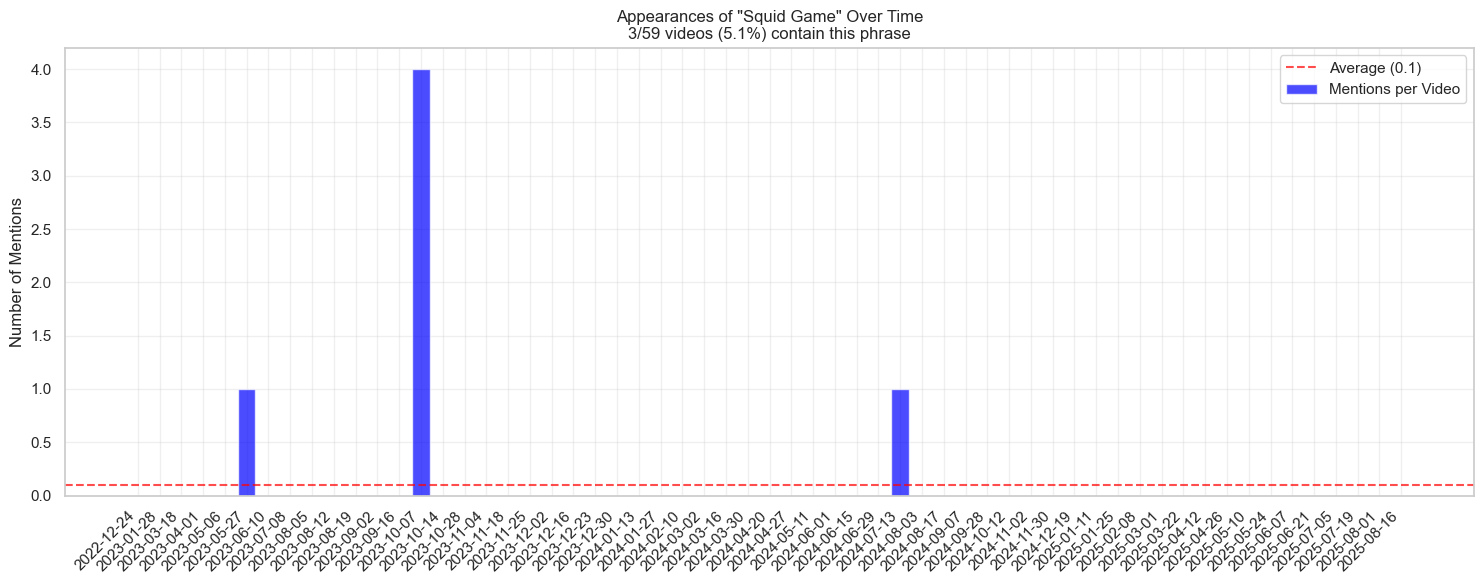

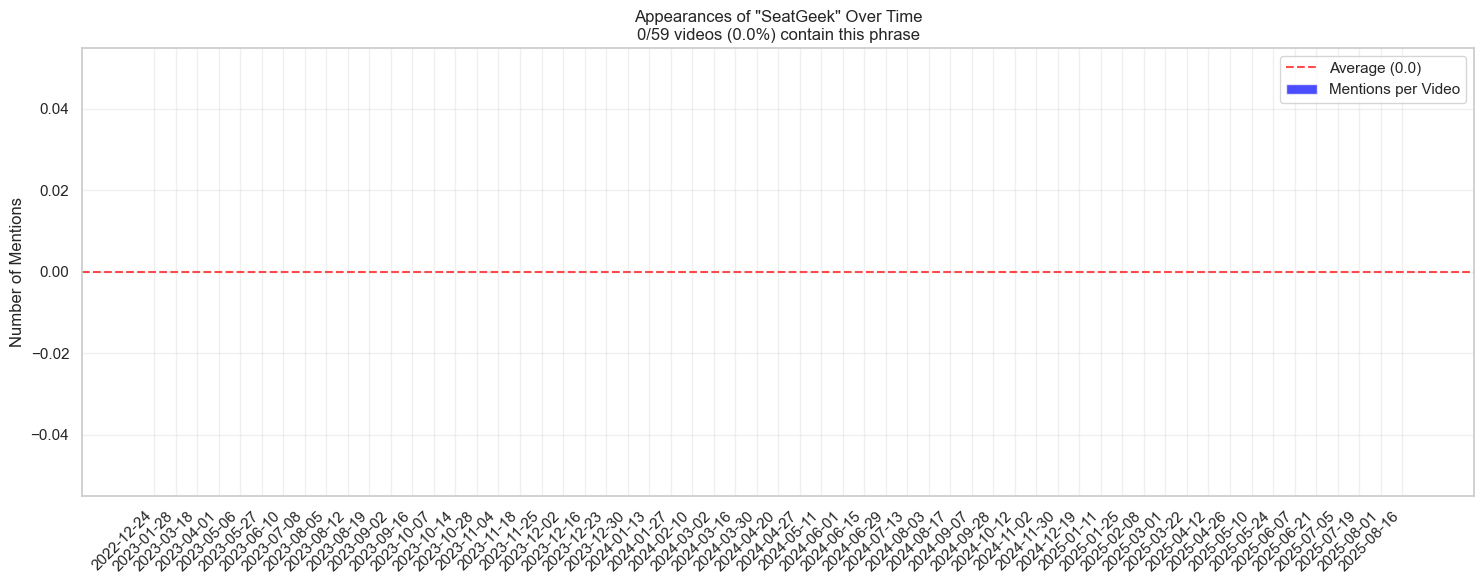

In [8]:
def plot_phrase_frequency_over_time(df, phrase):
    plt.figure(figsize=(15, 6))
    df_sorted = df.sort_values('date')
    counts = df_sorted[phrase]
    dates = df_sorted['date']
    avg = counts.mean()
    videos_with_mentions = (counts > 0).sum()
    total_videos = len(counts)
    percentage = (videos_with_mentions / total_videos) * 100
    x_positions = range(len(counts))
    plt.bar(x_positions, counts, alpha=0.7, color='blue', label='Mentions per Video')
    plt.axhline(y=avg, color='red', linestyle='--', alpha=0.7, label=f'Average ({avg:.1f})')
    plt.xticks(x_positions, [d.strftime('%Y-%m-%d') if pd.notna(d) else '' for d in dates], rotation=45, ha='right')
    plt.title(f'Appearances of "{phrase}" Over Time\n{videos_with_mentions}/{total_videos} videos ({percentage:.1f}%) contain this phrase')
    plt.xlabel('')
    plt.ylabel('Number of Mentions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

for phrase in SEARCH_PHRASES.keys():
    plot_phrase_frequency_over_time(df, phrase)


In [9]:
def get_recent_contexts(df, phrase, n=5):
    all_matches = []
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({'date': row['date'], 'title': row.get('title',''), 'context': match})
        if len(all_matches) >= n:
            break
    return pd.DataFrame(all_matches[:n])

for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d') if pd.notna(row['date']) else ''}")
            print(f"Title: {row['title']}")
            print(f"Context: {row['context']}\n")



=== Recent usage of 'Million' ===

Date: 2025-08-16
Title: Survive 100 Days In Prison, Win $500,000
Context: i built this maximum
security prison, and if this cop and this criminal
survive 100 days together, i will give them
half a million dollars. - what's going on?
- nice to officially meet you. - nice to meet you. lenny.
- ian. you guys want to be
uncuffed? that'd be great. now that that's
out the way… at any point over the next 100...

Date: 2025-08-16
Title: Survive 100 Days In Prison, Win $500,000
Context: ...ow that that's
out the way… at any point over the next 100 days, if either of you decide to leave,
you’ll both get nothing. have you guys ever seen
$500,000 in real life? never. well, i owed a half a million
when i got out of prison. does that count? how long were
you a cop? 17 years. how long were you a… …criminal? 3 years in
federal prison. how do these compare
to the prison you were in? these are a li...

Date: 2025-08-16
Title: Survive 100 Days In Prison, Win $500,000
C